<a href="https://colab.research.google.com/github/JasaZnidar/Predvidenje-zmagovalca-vaterpolo/blob/mathematics-all3/Diplomska_naloga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [4]:
# @title Imports
import json
import requests
from zipfile import ZipFile
from io import BytesIO
import numpy as np
import random
from math import sqrt, pow, isnan, log
from typing import Callable
from sys import float_info
from functools import lru_cache
import copy
from statistics import mean
import torch, torchvision
import matplotlib.pyplot as plt
from typing import Union

import warnings

# Support functions

In [5]:
# @title Event data to vector data
def eventToVector(event: dict) -> tuple[list[float], list[float]]:
  player1Statistic = [0.0]*11
  player2Statistic = [0.0]*11

  if "goal scored" in event['action']:
    # goals
    player1Statistic[0] += 1
    # shots
    player1Statistic[1] += 1
    # assists
    player2Statistic[2] += 1

  elif "exclusion" in event['action']:
    # exclusion
    player1Statistic[5] += 1

  elif "penalty foul" in event['action']:
    # penalty
    player1Statistic[6] += 1

  elif "shot missed" in event['action']:
    # shots
    player1Statistic[1] += 1

  elif "shot saved" in event['action']:
    # shots
    player1Statistic[1] += 1

  elif "shot blocked" in event['action']:
    # shots
    player1Statistic[1] += 1
    # blocks
    player2Statistic[3] += 1

  elif "suspention" in event['action']:
    # suspensions
    player1Statistic[7] += 1

  elif "brutality" in event['action']:
    # brutalities
    player1Statistic[8] += 1

  elif "sprint won" in event['action']:
    # sprint won
    player1Statistic[9] += 1
    # sprint
    player1Statistic[10] += 1
    # sprint
    player2Statistic[10] += 1

  return (player1Statistic, player2Statistic);

In [6]:
# @title Is second player ally
def isAlly(event: dict) -> bool:
  if 'goal scored' in event['action']:
    return True
  return False

In [7]:
# @title Update list
def Update(original: list, update: list) -> list:
  assert len(original) == len(update)

  return[original[x] + update[x] for x in range(len(original))]

In [8]:
# @title Resize array by mask
def resizeByMask(array: np.array, mask: list):
  retArray = []
  for i in range(len(mask)):
    if mask[i]:
      retArray.append(array[i])

  return np.array(retArray)

In [9]:
# @title Classification
def classify(val: float, allowTie: bool = True):
  if allowTie:
    if val >= 0.5:
      return 1
    elif val <= -0.5:
      return -1
    return 0
  else:
    if val >= 0:
      return 1
    return -1

In [10]:
# @title Team data normalization
def normTeamData(data: list[list[float], float]) -> list[float]:
  if data[1] == 0:
    return [0.0]*num_playerInMatch_features
  return (np.array(data[0])/data[1]).tolist()

In [11]:
# @title Clustering functions
def manhattan_dist(r1: np.array, r2: np.array) -> float:
  return np.nanmean(abs(r1 - r2))

def euclidean_dist(r1: np.array, r2: np.array) -> float:
  return sqrt(np.nanmean((r1 - r2)**2))

def single_linkage(c1: list, c2: list, distance_fn: Callable) -> float:
  dist = np.array([distance_fn(p1, p2) for p2 in c2 for p1 in c1])
  return np.nanmin(dist)


def complete_linkage(c1: list, c2: list, distance_fn: Callable) -> float:
  dist = np.array([distance_fn(p1, p2) for p2 in c2 for p1 in c1])
  return np.nanmax(dist)


def average_linkage(c1: list, c2: list, distance_fn: Callable) -> float:
  dist = np.array([distance_fn(p1, p2) for p2 in c2 for p1 in c1])
  return np.nanmean(dist)


def singleDim(l: list) -> list:
  # are there multiple layers
  if type(l) == list:
    ret = []
    for l_i in l:
      ret += singleDim(l_i)

    return ret

  # the list can't be broken down further
  else:
    if type(l) == str:
      return [l]

    # value is distance
    return []


def silhouette(el: str, clusters: list, data: dict) -> float:
  distance = euclidean_dist

  # locate local cluster
  for I in range(len(clusters)):
    cluster_I = singleDim(clusters[I])
    if el in cluster_I:
      a_el = 0

      if len(cluster_I) == 1:
        return 0.0

      for c in cluster_I:
        a_el += distance(data[el], data[c])
      a_el /= len(cluster_I) - 1

      b_el = float_info.max
      for J in range(len(clusters)):
        if J == I:
          continue

        b_new = 0
        cluster_J = singleDim(clusters[J])
        for c in cluster_J:
          b_new += distance(data[el], data[c])
        b_new /= len(cluster_J)

        b_el = min(b_el, b_new)

      s_el = (b_el - a_el)/max(a_el, b_el)
      return s_el


def silhouette_average(data: dict, clusters: list) -> float:
  cluster = singleDim(clusters)
  ret = 0
  for el in cluster:
    ret += silhouette(el, clusters, data)
  ret /= len(cluster)

  return ret

# Data Setup

In [12]:
# @title Data settings
data_file = "test"
train_rate = 0.7
val_rate = 1.0 - train_rate

# goals, shots, assists, blocks, saves, exclusion, penalty foul, suspention, brutality, sprint won, sprints
used_features = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]#[1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]#
num_playerInMatch_features = sum(used_features)
# birth, hand height, position, weight
used_player_stats = [1, 1, 1, 1, 1]
num_player_features = sum(used_player_stats)

In [13]:
# @title Get JSON data from github
with requests.get(f"https://github.com/JasaZnidar/totalwaterpolo-web-scraper/raw/master/{data_file}.zip", ) as r:
  ZipFile(BytesIO(r.content), "r").extractall()

In [14]:
# @title Extract data to json object
with open(f"/content/{data_file}.json") as f:
    scraped_data = json.load(f)

In [15]:
# @title Team and Match data
def getData(matches: dict[str, dict], stop: int = None, skipTie: bool = False):
  match_list = [match_id for match_id in matches]
  if stop is not None:
    match_list = match_list[:stop]

  match_data = {}
  team_data = {}

  for match_id in match_list:
    #=============================================================================
    # Collect match data
    #=============================================================================
    match_data[match_id] = [
        matches[match_id]['result']['away'] - matches[match_id]['result']['home'],
        matches[match_id]['name']['home'],
        matches[match_id]['name']['away'],
        [],
        []
    ]

    #=============================================================================
    # Check if ties are skipped
    #=============================================================================
    if skipTie and match_data[match_id][0] == 0:
      del match_data[match_id]
      continue

    #=============================================================================
    # Prepare statistics dictionary for a teams players
    #=============================================================================
    statistics = {
        'home': {int(x): [0.0]*num_playerInMatch_features for x in matches[match_id]['lineup']['home']},
        'away': {int(x): [0.0]*num_playerInMatch_features for x in matches[match_id]['lineup']['away']}
    }

    if len(statistics['home']) < 7 or len(statistics['away']) < 7:
      del match_data[match_id]
      continue

    #=============================================================================
    # Add missing teams in team_data
    #=============================================================================
    for team in ['home', 'away']:
      if not matches[match_id]['name'][team] in team_data:
        team_data[matches[match_id]['name'][team]] = [[0.0]*num_playerInMatch_features, 0]

    #=============================================================================
    # Loop through all events and update player statistics
    #=============================================================================
    for event in matches[match_id]['plays']:
      num_1 = event['player_1']
      num_2 = event['player_2']
      primary_team = event['team']
      secondary_team = primary_team if isAlly(event) else 'away' if primary_team == 'home' else 'home'

      # no player was recorded for this event
      if num_1 == 0:
        continue

      # no secondary player was recorded for this event
      elif num_2 == 0:
        data_1, _ = eventToVector(event)
        statistics[primary_team][num_1] = Update(statistics[primary_team][num_1], resizeByMask(data_1, used_features))

      # there are 2 players recorded for this event
      else:
        data_1, data_2 = eventToVector(event)
        statistics[primary_team][num_1] = Update(statistics[primary_team][num_1], resizeByMask(data_1, used_features))
        statistics[secondary_team][num_2] = Update(statistics[secondary_team][num_2], resizeByMask(data_2, used_features))

    #=============================================================================
    # Update match data
    #=============================================================================
    match_data[match_id][3] = team_data[matches[match_id]['name']['home']].copy()
    match_data[match_id][4] = team_data[matches[match_id]['name']['away']].copy()

    #=============================================================================
    # Update team overall data
    #=============================================================================
    for team in ['home', 'away']:
      team_name = matches[match_id]['name'][team]

      for player in statistics[team]:
        team_data[team_name][0] = Update(team_data[team_name][0], statistics[team][player])
        team_data[team_name][1] += 1

  return (match_data, team_data)

match_data, team_data = getData(scraped_data['matches'])
noTieMatch_data, noTieTeam_data = getData(scraped_data['matches'], skipTie=True)

# Models

In [16]:
# @title Statistics
class Statistics:
  def __init__(self, match_data: dict[str, list[int, str, str, list[float], list[float]]]):
    self.match_data = match_data
    self.resultStats = [0, 0, 0] # from home perspective: [win, tie, loss]

    for match_id in scraped_data['matches']:
      lineup = scraped_data['matches'][match_id]['lineup']
      if len(lineup['home']) < 7 or len(lineup['away']) < 7:
        continue

      diff = scraped_data['matches'][match_id]['result']['home'] - scraped_data['matches'][match_id]['result']['away']
      if diff > 0:
        self.resultStats[0] += 1
      elif diff < 0:
        self.resultStats[2] += 1
      else:
        self.resultStats[1] += 1

  def Predict(self):
    stats = [
        self.resultStats[0] / sum(self.resultStats),
        self.resultStats[1] / sum(self.resultStats),
        self.resultStats[2] / sum(self.resultStats)
    ]
    values = [1, 0, -1]

    return values[np.argmax(stats)]



In [17]:
# @title k-mean Clustering
class kMeanCluster:
  def __init__(self, k: int, match_data: dict[str, list]):
    assert k > 1

    self.centroids = np.zeros((k, 2*num_playerInMatch_features))
    match_vectors = {match_id: np.concatenate((normTeamData(match_data[match_id][3]), normTeamData(match_data[match_id][4]))) for match_id in match_data.keys()}

    # select select starting points as clusters (first one will be close to zero and the others as far appart from each other as possible)
    match_list = list(match_data.keys())
    clusters = []
    init_cluster = []

    # first point
    dist_0 = [np.sum(np.abs(match_vectors[match_list[n]])) for n in range(len(match_list))]
    n = np.argmin(dist_0)
    self.centroids[0, :] = match_vectors[match_list[n]]
    clusters.append([match_list[n]])
    init_cluster.append(n)

    for i in range(1, k):
      # distances from already chosen points
      dist = [0.0 if n in init_cluster else mean([np.sum(np.abs(match_vectors[match_list[m]] - match_vectors[match_list[n]])) for m in init_cluster]) for n in range(len(match_list))]

      n = np.argmax(dist)
      self.centroids[i, :] = match_vectors[match_list[n]]
      clusters.append([match_list[n]])
      init_cluster.append(n)

    # split into clusters
    #print(clusters)
    for i in range(len(match_list)):
      if i in init_cluster:
        continue
      match_vector = match_vectors[match_list[i]]
      dist = self.distance(match_vector)
      closest = np.argmin(dist)

      clusters[closest].append(match_list[i])

    #self.ClusterSize(clusters)

    # update clusters until they are no longer updated
    change = True
    while change:
      # update centroids
      for i in range(k):
        self.centroids[i, :] = np.mean(np.array([match_vectors[match_id] for match_id in clusters[i]]), axis=0)

      # calculate new clusers
      new_clusters = [[] for _ in range(k)]
      for i in range(len(match_list)):
        match_vector = match_vectors[match_list[i]]
        dist = self.distance(match_vector)
        closest = np.argmin(dist)

        new_clusters[closest].append(match_list[i])

      # compare old and new clusters
      change = False
      for i in range(k):
        if not len(clusters[i]) == len(new_clusters[i]):
          #print(f"Size in new cluster {i+1} is {len(new_clusters[i])} instead of {len(clusters[i])}.")
          change = True
          break
        for j in range(len(clusters[i])):
          if clusters[i][j] not in new_clusters[i]:
            #print(f"Match {clusters[i][j]} was not found in new cluster, was moved.")
            change = True
            break

      clusters = new_clusters
      #self.ClusterSize(clusters)

    # calculate centroid values
    self.centroid_values = [mean([match_data[match_id][0] for match_id in cluster]) for cluster in clusters]
    #print(self.centroid_values)

  def distance(self, vector):
    return [np.sum(np.abs(self.centroids[i, :] - vector)) for i in range(self.centroids.shape[0])]

  def ClusterSize(self, clusters):
    print(f"[", end="")
    for i in range(len(clusters)):
      print(f"{len(clusters[i])}", end="")
      if i != len(clusters) - 1:
        print(f", ", end="")
    print(f"]")

    return

  def Predict(self, home_team: str, away_team: str, team_data: dict[str, list[float]]):
    if home_team not in team_data:
      home = np.zeros((num_playerInMatch_features,))
    else:
      home = normTeamData(team_data[home_team])

    if away_team not in team_data:
      away = np.zeros((num_playerInMatch_features,))
    else:
      away = normTeamData(team_data[away_team])

    match_vector = np.concatenate((home, away))

    dist = self.distance(match_vector)
    closest = np.argmin(dist)

    return self.centroid_values[closest]

In [18]:
# @title Hierarchical clustering
class HierarchicalClustering:
  def __init__(self, link_function: Callable, dist_function: Callable, match_data: dict[str, list], max_dist: float = 0.3):
    self.dist = dist_function
    self.link = link_function
    self.return_distances = True
    self.match_results = {match_id: match_data[match_id][0] for match_id in match_data.keys()}

    self.data = {}
    self.results = {}
    for match_id in match_data:
      home = normTeamData(match_data[match_id][3])
      away = normTeamData(match_data[match_id][4])
      self.data[match_id] = np.concatenate((home, away))
      self.results[match_id] = match_data[match_id][0]

    clusters = [[name] for name in self.data.keys()]
    self.clusterStrings = [name for name in self.data.keys()]
    distance = 0.0

    # create clusters
    while len(clusters) >= 2:
      print(f"\r{len(clusters)} - {distance:.4}", end="")
      first, second, distance = self.closest_clusters(clusters)

      # check if dist is too large
      if distance > max_dist:
        break

      # update the "clusters" variable
      c1_i = clusters.index(first)
      c2_i = clusters.index(second)

      # c1_i < c2_i
      del clusters[c2_i]
      if self.return_distances:
        clusters[c1_i] = [first, second, distance]
      else:
        clusters[c1_i] = [first, second]
      self.clusterStrings[c1_i] += "," + self.clusterStrings[c2_i]
      del self.clusterStrings[c2_i]

    self.clusters = clusters

    # classify clusters
    self.classification = [float(np.mean(np.array([self.match_results[match_id] for match_id in clusterString.split(",")]))) for clusterString in self.clusterStrings]

  @lru_cache(maxsize=None)
  def dist_cache(self, match1: str, match2: str) -> float:
    c1 = self.data[match1]
    c2 = self.data[match2]

    return self.dist(c1, c2)

  @lru_cache(maxsize=None)
  def link_cache(self, cluster1: str, cluster2: str):
    matches1 = cluster1.split(",")
    matches2 = cluster2.split(",")

    return self.link(matches1, matches2, self.dist_cache)

  def closest_clusters(self, clusters: list) -> tuple[list[str], list[str], float]:
    # starting clusters
    c1 = clusters[0]
    c2 = clusters[1]

    # first distance and length
    dist = self.link_cache(self.clusterStrings[0], self.clusterStrings[1])
    C = len(clusters)

    for i in range(C):
      for j in range(i+1, C):
        new_dist = self.link_cache(self.clusterStrings[i], self.clusterStrings[j])
        if isnan(new_dist):
          continue

        if isnan(dist) or new_dist < dist:
          dist = new_dist
          c1 = clusters[i]
          c2 = clusters[j]

    return (c1, c2, dist)

  def Predict(self, home_team: str, away_team: str, team_data: dict[str, list[float]]):
    if home_team not in team_data:
      home = np.zeros((num_playerInMatch_features,))
    else:
      home = normTeamData(team_data[home_team])

    if away_team not in team_data:
      away = np.zeros((num_playerInMatch_features,))
    else:
      away = normTeamData(team_data[away_team])


    match_data = np.concatenate((home, away))

    # calculate distance
    links = np.array([self.link([match_data], [self.data[match_id] for match_id in clusterStr.split(",")], self.dist) for clusterStr in self.clusterStrings])

    # get prediction value
    closestCluster = np.argmin(links)
    return self.classification[closestCluster]

In [19]:
# @title KNN
class KNN:
  def __init__(self, k: int, team_data: dict[str, list[list[float], int]], match_history: dict[str, list[int, str, str, list[float], list[float]]]):
    self.k = k

    teams = list(team_data.keys())
    self.team_data = {
        team: normTeamData(team_data[team])
        for team in team_data
    }
    self.match_history = match_history

  def Predict(self, friendly_team: str, enemy_team: str, friendly_home: bool = None) -> float:
    if friendly_team not in self.team_data and enemy_team not in self.team_data:
      # both teams are unknown, return tie
      return 0

    if enemy_team not in self.team_data:
      # enemy team has no history, reverse the question and then the answer
      return -self.Predict(enemy_team, friendly_team, not friendly_home)

    # collect all teams who played against the enemy team
    neighbors = set([])
    neighbor_results = {}
    for match_id in self.match_history:
      history_match = self.match_history[match_id]

      # friendly team is not home team => enemy team is home
      if friendly_home != True and history_match[1] == enemy_team:
        neighbors.add(history_match[2])
        if history_match[2] not in neighbor_results:
          neighbor_results[history_match[2]] = []
        neighbor_results[history_match[2]].append(history_match[0])

      # friendly team is not away team => enemy team is away
      if friendly_home != False and history_match[2] == enemy_team:
        neighbors.add(history_match[1])
        if history_match[1] not in neighbor_results:
          neighbor_results[history_match[1]] = []
        neighbor_results[history_match[1]].append(history_match[0])

    # form a neighbor matrix for distnce
    neighbor_matrix = np.zeros((len(neighbors), num_playerInMatch_features))
    neighbor_index = []
    for neighbor in neighbors:
      neighbor_matrix[len(neighbor_index), :] = self.team_data[neighbor]
      neighbor_index.append(neighbor)

    # calculate distance
    if friendly_team not in self.team_data:
      neighbor_distance = (neighbor_matrix)**2
    else:
      neighbor_distance = (neighbor_matrix - self.team_data[friendly_team])**2
    neighbor_distance = np.nansum(neighbor_distance, axis=1)

    # select k nearest neighbors, if possible
    modifier = 1
    if len(neighbor_distance) < self.k:
      knn_index = [n for n in range(len(neighbor_distance))]
      modifier = len(neighbor_distance)/self.k  # normalize data to match uncertanty
      if len(neighbor_distance) == 0:
        # enemy team has no history, reverse the question and then the answer
        return 0
      #warnings.warn("Not enough neighbors to make a full prediction. Prediction will be made with {} neighbors instead of {}.".format(len(neighbor_distance), self.k))
    elif len(neighbor_distance) == self.k:
      knn_index = [n for n in range(len(neighbor_distance))]
    else:
      knn_index = np.argpartition(neighbor_distance, self.k)[:self.k]

    # calculate prediction
    pred = 0.0
    weight = 0.0
    for i in knn_index:
      for result in neighbor_results[neighbor_index[i]]:
        pred += result * (1/(neighbor_distance[i] + 1))
        weight += 1/(neighbor_distance[i] + 1)
    pred /= weight

    return pred

In [20]:
# @title Linear regresion
def gradient(X: np.ndarray, y: np.ndarray, theta: np.ndarray, l2_lambda: float) -> np.array:
    _, m = X.shape
    L2 = np.ones((m,)) * l2_lambda
    L2[0] = 0.0

    return np.dot(np.dot(X, theta) - y, X) + L2*theta


def gradient_descent(X: np.ndarray, y: np.ndarray, l2_lambda: float, lr=0.01, tol=1e-6, max_iter=100_000) -> np.array:
    _, m = X.shape
    theta = np.ones((m, ))

    for _ in range(max_iter):
        theta_next = theta - lr*gradient(X, y, theta, l2_lambda)

        if np.isinf(theta_next).any() or np.isnan(theta_next).any():
            return theta

        diff = np.linalg.norm(gradient(X, y, theta_next, l2_lambda))
        if np.isinf(diff):
          raise Exception("Diff is inf.")
        if np.isnan(diff):
          raise Exception("Diff is nan.")

        if diff < tol:
            return theta_next

        theta = theta_next

    return theta

class LinReg:
  def __init__(self, match_history: dict[str, list[int, str, str, list[float], list[float]]]):
    # prepare learning data
    X = np.zeros((len(match_history), 2*num_playerInMatch_features))
    y = np.zeros((len(match_history)))

    # fill out learning data
    match_list = list(match_history.keys())
    for i in range(len(match_list)):
      match_id = match_list[i]
      home_data = normTeamData(match_history[match_id][3])
      away_data = normTeamData(match_history[match_id][4])

      X[i, :] = np.concatenate((home_data, away_data))
      y[i] = match_history[match_id][0] # result

    # add coeficient to X
    X_ = np.concatenate((np.ones((len(match_history), 1)), X), axis=1)

    # gradient descent
    theta = gradient_descent(X_, y, 0.0, 1e-5, 1e-8, 1_000_000)

    self.coefs = theta[1:]
    self.intercept = theta[0]

  def Predict(self, home_team: str, away_team: str, team_data: dict[str, list[float]]):
    if home_team not in team_data or away_team not in team_data:
      home = np.zeros((num_playerInMatch_features,))
    else:
      home = np.array(team_data[home_team][0])/team_data[home_team][1]

    if away_team not in team_data:
      away = np.zeros((num_playerInMatch_features,))
    else:
      away = np.array(team_data[away_team][0])/team_data[away_team][1]

    home = np.reshape(home, (1, -1))
    away = np.reshape(away, (1, -1))

    X_ = np.concatenate((np.ones((1, 1)), home, away), axis=1)
    theta = np.insert(self.coefs, 0, self.intercept)

    return np.dot(X_, theta)[0]

In [21]:
# @title Logistic regression
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def logGradient(X: np.ndarray, y: np.ndarray, theta: np.ndarray, l2_lambda: float) -> np.array:
    _, m = X.shape
    L2 = np.ones((m,)) * l2_lambda

    return np.dot(sigmoid(np.dot(X, theta)) - y, X) + L2*theta


def logGradient_descent(X: np.ndarray, y: np.ndarray, l2_lambda: float, lr=0.01, tol=1e-6, max_iter=100_000) -> np.array:
    _, m = X.shape
    theta = np.ones((m, ))

    for _ in range(max_iter):
      theta_next = theta - lr*logGradient(X, y, theta, l2_lambda)

      if np.isinf(theta_next).any() or np.isnan(theta_next).any():
          return theta

      diff = np.linalg.norm(logGradient(X, y, theta_next, l2_lambda))
      if np.isinf(diff):
        raise Exception("Diff is inf.")
      if np.isnan(diff):
        raise Exception("Diff is nan.")

      if diff < tol:
          return theta_next

      theta = theta_next

    return theta

class LogReg:
  def __init__(self, match_history: dict[str, list[int, str, str, list[float], list[float]]]):
    # prepare learning data
    X = np.zeros((len(match_history), 2*num_playerInMatch_features))
    y = np.zeros((len(match_history)))

    # fill out learning data
    match_list = list(match_history.keys())
    for i in range(len(match_list)):
      match_id = match_list[i]
      home_data = normTeamData(match_history[match_id][3])
      away_data = normTeamData(match_history[match_id][4])
      if np.isnan(home_data).any() or np.isnan(away_data).any():
        print(match_id)
        print(match_history[match_id])

      X[i, :] = np.concatenate((home_data, away_data))
      y[i] = match_history[match_id][0] # result

    # prepare logistic y
    yWin = y >= 0.5;
    yLoss = y <= -0.5;
    yTie  = np.logical_not(np.logical_or(yWin, yLoss))

    # gradient descent
    L2 = 0.0
    lr = 1e-5
    tol = 1e-8
    max_iter = 1_000_000
    self.thetaWin = logGradient_descent(X, yWin, L2, lr, tol, max_iter)
    self.thetaTie = logGradient_descent(X, yTie, L2, lr, tol, max_iter)
    self.thetaLoss = logGradient_descent(X, yLoss, L2, lr, tol, max_iter)

  def Predict(self, home_team: str, away_team: str, team_data: dict[str, list[float]]):
    if home_team not in team_data or away_team not in team_data:
      home = np.zeros((num_playerInMatch_features,))
    else:
      home = np.array(team_data[home_team][0])/team_data[home_team][1]

    if away_team not in team_data:
      away = np.zeros((num_playerInMatch_features,))
    else:
      away = np.array(team_data[away_team][0])/team_data[away_team][1]

    home = np.reshape(home, (1, -1))
    away = np.reshape(away, (1, -1))

    X_ = np.concatenate((home, away), axis=1)

    win = sigmoid(np.dot(X_, self.thetaWin))[0]
    tie = sigmoid(np.dot(X_, self.thetaTie))[0]
    loss = sigmoid(np.dot(X_, self.thetaLoss))[0]

    return np.argmax([loss, tie, win]) - 1

In [22]:
# @title Neural Network
def dataToMatrix(match_data: dict[str, list[int, str, str, list[float], list[float]]]) -> torch.Tensor:
  X = torch.zeros(len(match_data), 2*num_playerInMatch_features)

  for i in range(len(match_data)):
    match_id = list(match_data.keys())[i]

    home_data = normTeamData(match_data[match_id][3])
    away_data = normTeamData(match_data[match_id][4])

    X[i, :] = torch.tensor(np.concatenate((home_data, away_data)))

  return X

In [31]:
# @title XGBoost

def SimilarityScore(residuals: list[float], previousProbability: list[float], l: int = 0) -> float:
  assert len(residuals) > 0
  assert len(residuals) == len(previousProbability)

  deljenec = 0.0
  for residual_i in residuals:
    deljenec += residual_i
  deljenec = deljenec**2

  deljivec = float(l)
  for prob_i in previousProbability:
    deljivec += prob_i*(1.0 - prob_i)

  if deljivec == 0.0:
    return 0.0
  return deljenec/deljivec

def Gain(Sim_left: float, Sim_right: float, Sim_root: float) -> float:
  return Sim_left + Sim_right - Sim_root

class Branch:
  def __init__(self, stat: int, delimiter: float, left: Union[float, 'Branch'], right: Union[float, 'Branch']):
    self.Stat = stat
    self.Delim = delimiter
    self.Left = left
    self.Right = right

  def Decide(self, statistic: list[float]) -> float:
    if statistic[self.Stat] < self.Delim:
      return self.Left if isinstance(self.Left, float) else self.Left.Decide(statistic)
    else:
      return self.Right if isinstance(self.Right, float) else self.Right.Decide(statistic)

class B:
  def ApplyChoice(self, stat: int, delimiter: float):
    self.Stat = stat
    self.Delim = delimiter

  def Choose(self, data: list[float]) -> bool:
    # left == True, right == False
    return data[self.Stat] < self.Delim

class Tree:
  def __init__(self):
    self.Branches = {}
    self.Children = {}
    self.Leaves = 0

  def SetRoot(self, branch: Union[float, B]):
    self.Branches[0] = branch
    self.Children[0] = []

    if self.Leaves == 0:
      self.Leaves = 1

  def AddBranch(self, parent: int, branch: Union[float, B]):
    id = len(self.Branches)
    if id == 0:
      self.SetRoot(branch)
      return

    assert type(self.Branches[parent]) == B

    self.Leaves += 1
    self.Branches[id] = branch
    self.Children[parent].append(id)
    if type(branch) == B:
      self.Children[id] = []

  def Decide(self, data: list[float]) -> float:
    id = 0
    while type(self.Branches[id]) == B:
      if self.Branches[id].Choose(data):
        id = self.Children[id][0]
      else:
        id = self.Children[id][1]

    return self.Branches[id]

class XGBoost:
  def __init__(self, data: list[list[float]], label: list[bool], lr: float = 0.1, l: int = 0, M: int = 8, maxTreeDepth: int = 3, g: float = 0.0, printTree: bool = False):
    assert len(data) == len(label)
    assert M > 0

    self.InitPredict = np.average(np.array(label)).item()
    self.Trees = []
    self.Lr = lr
    self.Lambda = l
    self.Gamma = g
    self.MaxDepth = maxTreeDepth

    self.Print = printTree

    #===========================================================================
    # Create trees
    #===========================================================================
    if self.Print:
      print(f"{self.InitPredict:.4}")
    for m in range(M):
      #=========================================================================
      # Find optimal delimiter stat and the delimiter position
      #=========================================================================
      if self.Print:
        print("")
      self.Trees.append(self.CreateTree(data, label, []))

  def CreateTree(self, data: list[list[float]], label: list[bool], used: list[int] = []):
    #===========================================================================
    # Get predictions
    #===========================================================================
    predictions = [self.Predict(x) for x in data]

    #===========================================================================
    # Find optimal delimiter stat and the delimiter position
    #===========================================================================
    maxGain = self.Gamma
    maxStat = None
    maxSplit = None
    for stat in range(len(data[0])):
      if stat in used:
        continue

      # Create 1D array of only stat values
      statData = [(data[i][stat], i) for i in range(len(data))]

      # Sort statData
      statData.sort(key=lambda x: x[0])
      statDataIndex = [x[1] for x in statData]

      # root similarity
      rootPred = [predictions[statData[i][1]] for i in statDataIndex]
      rootResidual = [rootPred[statData[i][1]] - float(int(label[statData[i][1]])) for i in statDataIndex]
      rootSim = SimilarityScore(rootResidual, rootPred, self.Lambda)

      # find ideal splitting location
      for split in range(1, len(statData)):
        # left values
        leftPred = rootPred[:split]
        leftResidual = rootResidual[:split]
        leftSim = SimilarityScore(leftResidual, leftPred, self.Lambda)

        # right values
        rightPred = rootPred[split:]
        rightResidual = rootResidual[split:]
        rightSim = SimilarityScore(rightResidual, rightPred, self.Lambda)

        # calculate new gain
        gain = Gain(leftSim, rightSim, rootSim)

        # compare gain
        if gain > maxGain:
          maxGain = copy.copy(gain)
          maxStat = copy.copy(stat)
          maxSplit = copy.copy(split)

    # print result
    space = "  "*len(used)
    if self.Print:
      print(f"{space}", end="")

    # process results
    newUsed = copy.copy(used)
    newUsed.append(maxStat)
    if maxStat == None or len(newUsed) >= self.MaxDepth:
      if self.Print:
        print(f" -> {mean(rootResidual):.4}")
      return mean(rootResidual)
    else:
      if self.Print:
        print(f" {maxStat: 2}")
      statData = [(data[i][maxStat], i) for i in range(len(data))]
      statData.sort(key=lambda x: x[0])

      leftData = [data[x[1]] for x in statData[maxSplit:]]
      leftLabel = [label[x[1]] for x in statData[maxSplit:]]

      rightData = [data[x[1]] for x in statData[:maxSplit]]
      rightLabel = [label[x[1]] for x in statData[:maxSplit]]

      if (maxSplit == len(statData) - 1):
        delimiter = statData[maxSplit][0]
      else:
        delimiter = (statData[maxSplit][0] + statData[maxSplit + 1][0])/2

      return Branch(maxStat, delimiter, self.CreateTree(leftData, leftLabel, newUsed), self.CreateTree(rightData, rightLabel, newUsed))


  def Predict(self, data: list[float], M: int = None) -> float:
    tree = [self.InitPredict] + self.Trees
    if not M == None:
      tree = tree[:M]

    prediction = 0.0

    for tree in tree:
      if type(tree) == Branch:
        prediction += self.Lr * tree.Decide(data)
      else:
        prediction += self.Lr * tree

    return prediction

class XGBoostClassifier:
  def __init__(self, data: list[list[float]], results: list[int], lr: float = 0.1, l: int = 0, M: int = 8, maxTreeDepth: int = 3, g: float = 0.0, printTree: bool = False):
    self.Classes = list(set(results))
    self.Labels = [ [self.Classes[i] == min(self.Classes, key=lambda x: abs(x-r)) for r in results] for i in range(len(self.Classes))]
    self.XGBoost = [ XGBoost(data, self.Labels[i], lr, l, M, maxTreeDepth, g, printTree) for i in range(len(self.Classes))]

  def Predict(self, data: list[float], M: int = None) -> int:
    if M == None:
      M = len(self.XGBoost[0].Trees)

    predictions = [x.Predict(data, M) for x in self.XGBoost]
    return self.Classes[np.argmax(predictions)]

# Train and test

In [24]:
N = 100

In [25]:
# @title Prepare train and test data
train_match_data, train_team_data = getData(scraped_data['matches'], -N)
train_noTieMatch_data, train_noTieTeam_data = getData(scraped_data['matches'], -N, True)

test_match_data = {}
for match_id in match_data:
  if match_id not in train_match_data:
    test_match_data[match_id] = match_data[match_id]
ground = [classify(test_match_data[match_id][0]) for match_id in test_match_data]

test_noTieMatch_data = {}
for match_id in noTieMatch_data:
  if match_id not in train_noTieMatch_data:
    test_noTieMatch_data[match_id] = noTieMatch_data[match_id]
noTieGround = [classify(test_noTieMatch_data[match_id][0]) for match_id in test_noTieMatch_data]

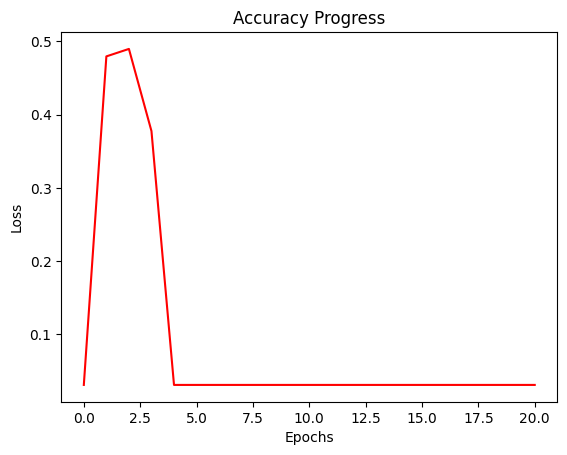

In [32]:
# @title XGBoost
lr = 0.1
l = 0
M = 20
maxTreeDepth = 5
g = 0.0

train_match_matrix = [normTeamData(train_match_data[id][3]) + normTeamData(train_match_data[id][4]) for id in train_match_data]
train_match_label = [classify(float(train_match_data[id][0])) for id in train_match_data]
test_match_matrix = [normTeamData(test_match_data[id][3]) + normTeamData(test_match_data[id][4]) for id in test_match_data]
test_match_label = [classify(float(test_match_data[id][0])) for id in test_match_data]

xgboost = XGBoostClassifier(train_match_matrix, train_match_label, lr, l, M, maxTreeDepth, g)

xgboost_preds = [[xgboost.Predict(test_match_matrix[i], m) for i in range(len(test_match_matrix))] for m in range(M+1)]
xgboost_acc = [np.average(np.array(xgboost_preds[m]) == np.array(test_match_label)) for m in range(M+1)]
#xgboost_pred = [xgboost.Predict(test_match_matrix[i]) for i in range(len(test_match_matrix))]
#print("Ties included:", np.average(np.array(xgboost_pred) == np.array(test_match_label)))

#===============================================================================
# Plot result
#===============================================================================
print("\r", end="")
warnings.filterwarnings("ignore", category=UserWarning, message="No artists with labels found to put in legend")

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax1.plot([m for m in range(M+1)], xgboost_acc, label='Loss', color='red')

plt.title("Accuracy Progress")
plt.show()




#train_noTieMatch_matrix = [normTeamData(train_noTieMatch_data[id][3]) + normTeamData(train_noTieMatch_data[id][4]) for id in train_noTieMatch_data]
#train_noTieMatch_label = [classify(float(train_noTieMatch_data[id][0]), False) for id in train_noTieMatch_data]
#test_noTieMatch_matrix = [normTeamData(test_noTieMatch_data[id][3]) + normTeamData(test_noTieMatch_data[id][4]) for id in test_noTieMatch_data]
#test_noTieMatch_label = [classify(float(test_noTieMatch_data[id][0])) for id in test_noTieMatch_data]

#xgboost_noTie = XGBoostClassifier(train_noTieMatch_matrix, train_noTieMatch_label, lr, l, M, maxTreeDepth, g)
#xgboost_noTie_pred = [xgboost_noTie.Predict(test_noTieMatch_matrix[i]) for i in range(len(test_noTieMatch_matrix))]
#print("Ties not included:", np.average(np.array(xgboost_noTie_pred) == np.array(test_noTieMatch_label)))

In [35]:
xgboost_pred = [xgboost.Predict(test_match_matrix[i]) for i in range(len(test_match_matrix))]
print("Ties included:", np.average(np.array(xgboost_pred) == np.array(test_match_label)))

Ties included: 0.030612244897959183


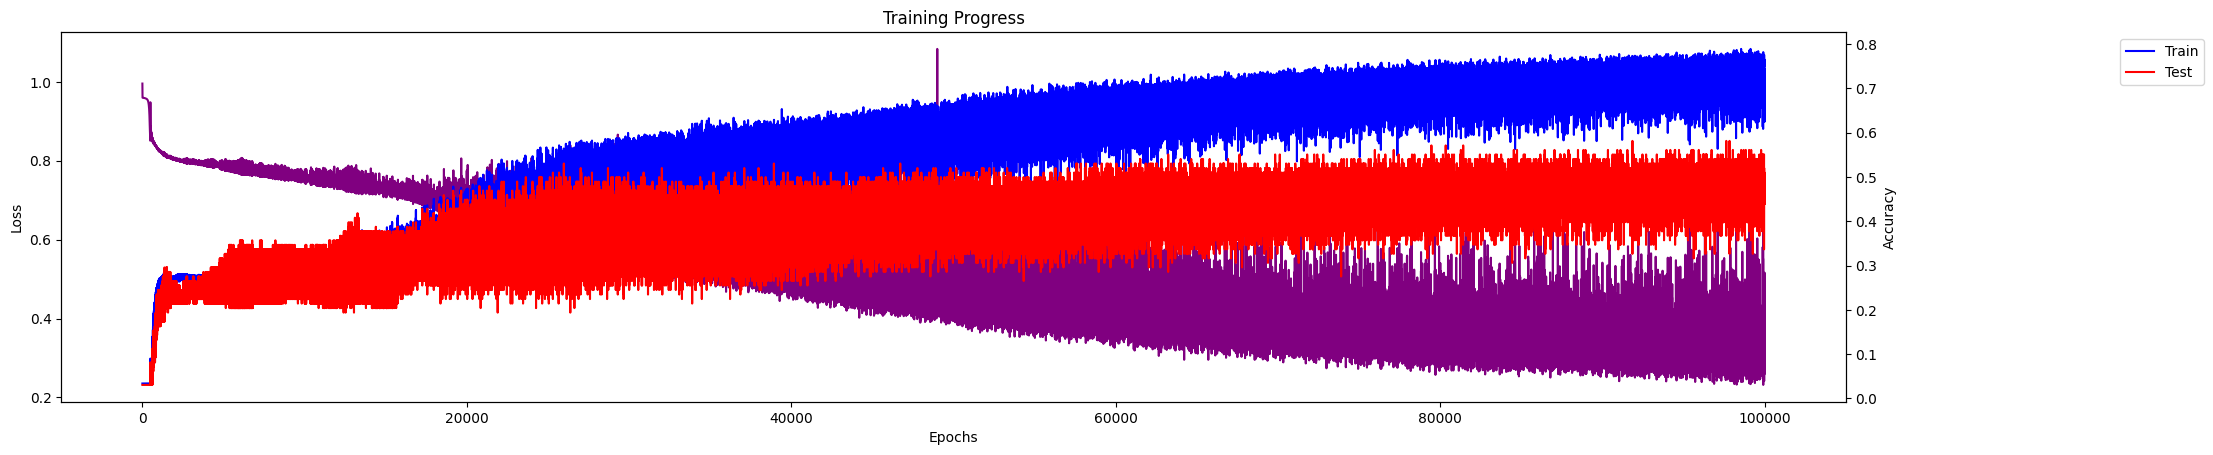

Train accuracy: 0.7403173121791881
Test accuracy: 0.45918367346938777


In [ ]:
# @title Neural Network
epoch = 100_000
lr = 0.1
crit = torch.nn.MSELoss()
vecSize = 2*num_playerInMatch_features

# with ties
train_match_matrix = dataToMatrix(train_match_data)
train_match_ground = torch.reshape(torch.tensor([float(classify(train_match_data[match_id][0])) for match_id in train_match_data]), (-1, 1))
test_match_matrix = dataToMatrix(test_match_data)
test_match_ground = torch.reshape(torch.tensor([float(classify(test_match_data[match_id][0])) for match_id in test_match_data]), (-1, 1))

NNMLP = torchvision.ops.MLP(vecSize, [vecSize, 2*vecSize, vecSize, num_playerInMatch_features, num_playerInMatch_features, 1])
optimizer = torch.optim.SGD(NNMLP.parameters(), lr=lr)

epochs = []
train_acc = []
train_loss = []
test_acc = []

for e in range(epoch):
  epochs.append(e+1)
  print(f"\rEpoch: {e+1} - {train_loss[-1] if len(train_loss) > 0 else -1}", end="", flush=True)

  # train
  NNMLP.train()
  optimizer.zero_grad()

  pred = NNMLP(train_match_matrix)

  loss = crit(pred, train_match_ground)
  train_loss.append(loss.item())
  loss.backward()
  optimizer.step()

  train_acc.append(np.average(np.array([classify(x.item()) for x in pred.reshape((-1))]) == np.array([classify(x.item()) for x in train_match_ground.reshape((-1))])))

  # test
  NNMLP.eval()
  pred = NNMLP(test_match_matrix)
  test_acc.append(np.average(np.array([classify(x.item()) for x in pred.reshape((-1))]) == np.array([classify(x.item()) for x in test_match_ground.reshape((-1))])))

#===============================================================================
# Plot result
#===============================================================================
print("\r", end="")
warnings.filterwarnings("ignore", category=UserWarning, message="No artists with labels found to put in legend")

fig, ax1 = plt.subplots()
fig.set_figwidth(log(epoch)*2)
ax2 = ax1.twinx()

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")

ax1.plot(epochs, train_loss, label='Loss', color='purple')
ax2.plot(epochs, train_acc, label='Train', color='blue')
ax2.plot(epochs, test_acc, label='Test', color='red')

plt.title("Training Progress")
plt.legend(labels=['Train', 'Test', 'Loss'], loc="upper left", bbox_to_anchor=(1.15, 1.0))
plt.show()

print("Train accuracy:", train_acc[-1])
print("Test accuracy:", test_acc[-1])





# without ties
#train_noTieMatch_matrix = dataToMatrix(train_noTieMatch_data)
#test_noTieMatch_matrix = dataToMatrix(test_noTieMatch_data)
#noTieNNMLP = torchvision.ops.MLP(2*num_playerInMatch_features, [4*num_playerInMatch_features, 4*num_playerInMatch_features, 1])

In [ ]:
# @title Statistics
# with ties
stats = Statistics(train_match_data)
stats_pred = []

for match_id in test_match_data:
  stats_pred.append(classify(stats.Predict()))

print("Ties included:", np.average(np.array(stats_pred) == np.array(ground)))

# without ties
noTieStats = Statistics(train_noTieMatch_data)
noTieStats_pred = []

for match_id in test_noTieMatch_data:
  noTieStats_pred.append(classify(noTieStats.Predict(), False))

print("Ties not included:", np.average(np.array(noTieStats_pred) == np.array(noTieGround)))

Ties included: 0.4897959183673469
Ties not included: 0.5052631578947369


In [ ]:
# @title k-mean Clustering - 2 clusters
# with ties
kMeanCluster2 = kMeanCluster(2, train_match_data)
kMeanCluster2_pred = []

for match_id in test_match_data:
  kMeanCluster2_pred.append(classify(kMeanCluster2.Predict(test_match_data[match_id][1], test_match_data[match_id][2], train_noTieTeam_data)))

print("Ties included:", np.average(np.array(kMeanCluster2_pred) == np.array(ground)))

# without ties
noTieKMeanCluster2 = kMeanCluster(2, train_noTieMatch_data)
noTieKMeanCluster2_pred = []

for match_id in test_noTieMatch_data:
  noTieKMeanCluster2_pred.append(classify(noTieKMeanCluster2.Predict(test_noTieMatch_data[match_id][1], test_noTieMatch_data[match_id][2], train_noTieTeam_data), False))

print("Ties not included:", np.average(np.array(noTieKMeanCluster2_pred) == np.array(noTieGround)))

Ties included: 0.11224489795918367
Ties not included: 0.49473684210526314


In [ ]:
# @title k-mean Clustering - 7 clusters
# with ties
kMeanCluster7 = kMeanCluster(7, train_match_data)
kMeanCluster7_pred = []

for match_id in test_match_data:
  kMeanCluster7_pred.append(classify(kMeanCluster7.Predict(test_match_data[match_id][1], test_match_data[match_id][2], train_noTieTeam_data)))

print("Ties included:", np.average(np.array(kMeanCluster7_pred) == np.array(ground)))

# without ties
noTieKMeanCluster7 = kMeanCluster(7, train_noTieMatch_data)
noTieKMeanCluster7_pred = []

for match_id in test_noTieMatch_data:
  noTieKMeanCluster7_pred.append(classify(noTieKMeanCluster7.Predict(test_noTieMatch_data[match_id][1], test_noTieMatch_data[match_id][2], train_noTieTeam_data), False))

print("Ties not included:", np.average(np.array(noTieKMeanCluster7_pred) == np.array(noTieGround)))

Ties included: 0.21428571428571427
Ties not included: 0.5263157894736842


In [ ]:
# @title k-mean Clustering - 8 clusters
# with ties
kMeanCluster8 = kMeanCluster(8, train_match_data)
kMeanCluster8_pred = []

for match_id in test_match_data:
  kMeanCluster8_pred.append(classify(kMeanCluster8.Predict(test_match_data[match_id][1], test_match_data[match_id][2], train_noTieTeam_data)))

print("Ties included:", np.average(np.array(kMeanCluster8_pred) == np.array(ground)))

# without ties
noTieKMeanCluster8 = kMeanCluster(8, train_noTieMatch_data)
noTieKMeanCluster8_pred = []

for match_id in test_noTieMatch_data:
  noTieKMeanCluster8_pred.append(classify(noTieKMeanCluster8.Predict(test_noTieMatch_data[match_id][1], test_noTieMatch_data[match_id][2], train_noTieTeam_data), False))

print("Ties not included:", np.average(np.array(noTieKMeanCluster8_pred) == np.array(noTieGround)))

Ties included: 0.5306122448979592
Ties not included: 0.5263157894736842


In [ ]:
# @title KNN - 3
# with ties
knn3 = KNN(3, train_team_data, train_match_data)
knn3_pred = []

for match_id in test_match_data:
  knn3_pred.append(classify(knn3.Predict(test_match_data[match_id][1], test_match_data[match_id][2], True)))

print("Ties included:", np.average(np.array(knn3_pred) == np.array(ground)))

# without ties
noTieKnn3 = KNN(3, train_noTieTeam_data, train_noTieMatch_data)
noTieKnn3_pred = []

for match_id in test_noTieMatch_data:
  noTieKnn3_pred.append(classify(noTieKnn3.Predict(test_noTieMatch_data[match_id][1], test_noTieMatch_data[match_id][2], True), False))

print("Ties not included:", np.average(np.array(noTieKnn3_pred) == np.array(noTieGround)))

Ties included: 0.5510204081632653
Ties not included: 0.631578947368421


In [ ]:
# @title KNN - 5
# with ties
knn5 = KNN(5, train_team_data, train_match_data)
knn5_pred = []

for match_id in test_match_data:
  knn5_pred.append(classify(knn5.Predict(test_match_data[match_id][1], test_match_data[match_id][2], True)))

print("Ties included:", np.average(np.array(knn5_pred) == np.array(ground)))

# without ties
noTieKnn5 = KNN(5, train_noTieTeam_data, train_noTieMatch_data)
noTieKnn5_pred = []

for match_id in test_noTieMatch_data:
  noTieKnn5_pred.append(classify(noTieKnn5.Predict(test_noTieMatch_data[match_id][1], test_noTieMatch_data[match_id][2], True), False))

print("Ties not included:", np.average(np.array(noTieKnn5_pred) == np.array(noTieGround)))

Ties included: 0.5408163265306123
Ties not included: 0.6421052631578947


In [ ]:
# @title KNN - 7
# with ties
knn7 = KNN(7, train_team_data, train_match_data)
knn7_pred = []

for match_id in test_match_data:
  knn7_pred.append(classify(knn7.Predict(test_match_data[match_id][1], test_match_data[match_id][2], True)))

print("Ties included:", np.average(np.array(knn7_pred) == np.array(ground)))

# without ties
noTieKnn7 = KNN(7, train_noTieTeam_data, train_noTieMatch_data)
noTieKnn7_pred = []

for match_id in test_noTieMatch_data:
  noTieKnn7_pred.append(classify(noTieKnn7.Predict(test_noTieMatch_data[match_id][1], test_noTieMatch_data[match_id][2], True), False))

print("Ties not included:", np.average(np.array(noTieKnn7_pred) == np.array(noTieGround)))

Ties included: 0.5306122448979592
Ties not included: 0.6631578947368421


In [ ]:
# @title Linear regression
# with ties
linreg = LinReg(train_match_data)
linreg_pred = []

for match_id in test_match_data:
  linreg_pred.append(classify(linreg.Predict(test_match_data[match_id][1], test_match_data[match_id][2], team_data)))

print("Ties included:", np.average(np.array(linreg_pred) == np.array(ground)))

# without ties
noTieLinreg = LinReg(train_noTieMatch_data)
noTieLinreg_pred = []

for match_id in test_noTieMatch_data:
  noTieLinreg_pred.append(classify(linreg.Predict(test_noTieMatch_data[match_id][1], test_noTieMatch_data[match_id][2], train_noTieTeam_data), False))

print("Ties not included:", np.average(np.array(noTieLinreg_pred) == np.array(noTieGround)))

Ties included: 0.673469387755102
Ties not included: 0.6947368421052632


In [ ]:
# @title Logistic regression
# with ties
logreg = LogReg(train_match_data)
logreg_pred = []

for match_id in test_match_data:
  logreg_pred.append(classify(logreg.Predict(test_match_data[match_id][1], test_match_data[match_id][2], team_data)))

print("Ties included:", np.average(np.array(logreg_pred) == np.array(ground)))

# without ties
noTieLogreg = LogReg(train_noTieMatch_data)
noTieLogreg_pred = []

for match_id in test_noTieMatch_data:
  noTieLogreg_pred.append(classify(noTieLogreg.Predict(test_noTieMatch_data[match_id][1], test_noTieMatch_data[match_id][2], train_noTieTeam_data), False))

print("Ties not included:", np.average(np.array(noTieLogreg_pred) == np.array(noTieGround)))

Ties included: 0.6836734693877551
Ties not included: 0.6947368421052632


In [ ]:
# @title Hierarchical clustering - 0.1 with ties
acc = 0.1
# with ties
cluster = HierarchicalClustering(average_linkage, euclidean_dist, train_match_data, acc)
cluster_pred = []

for match_id in test_match_data:
  cluster_pred.append(classify(cluster.Predict(test_match_data[match_id][1], test_match_data[match_id][2], team_data)))

print("\rTies included:", np.average(np.array(cluster_pred) == np.array(ground)))

In [ ]:
# @title Hierarchical clustering - 0.1 without ties
acc = 0.1
# without ties
noTieCluster = HierarchicalClustering(average_linkage, euclidean_dist, train_noTieMatch_data, acc)
noTieCluster_pred = []

for match_id in test_noTieMatch_data:
  noTieCluster_pred.append(classify(noTieCluster.Predict(test_noTieMatch_data[match_id][1], test_noTieMatch_data[match_id][2], train_noTieTeam_data), False))

print("\rTies not included:", np.average(np.array(noTieCluster_pred) == np.array(noTieGround)))